In [1]:
import sys, os, platform, random, glob
from tabulate import tabulate

path = os.path.abspath('./aux/')
if path not in sys.path:
    sys.path.append(path)

import numpy as np
import pandas as pd
import nibabel as nib
import scipy as scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing, svm, metrics

from scipy.cluster.hierarchy import dendrogram, linkage

from aux import default_config as df_conf
from aux import func as sign
from aux import aux_fnc as ax

print('Python version: ', platform.python_version())
print('Numpy version: ', np.version.version)
print('Scipy version: ', scipy.__version__)
print('Matplotlib version: ', mpl.__version__)

Python version:  3.7.1
Numpy version:  1.15.4
Scipy version:  1.1.0
Matplotlib version:  3.0.2


In [2]:
labeled_file = './aux/labels.csv'
all_labels = pd.read_csv(labeled_file,sep=',')

group_opts = ['Freesurfer','Manual','Pardoe']
dirs_all = []
labels_all = []
for group_opt in group_opts:
    str_add = ''
    if group_opt == 'Freesurfer':
        str_add = 'T1_'

    list_opt = all_labels.loc[(all_labels['Label'] != -1) & (all_labels['Group'] == group_opt)]
    dirs_all += ['{}{}/{}{:06.0f}/'.format(df_conf.DIR_BAS,group_opt.lower(),str_add,cod) for cod in list_opt.Subject]
    labels_all += list(list_opt.Label)
#dirs_all, labels_all = dirs_all[:60], labels_all[:60]
print('Found dirs:',len(dirs_all))

Found dirs: 767


Segmentations' vector:  (767, 26, 500)


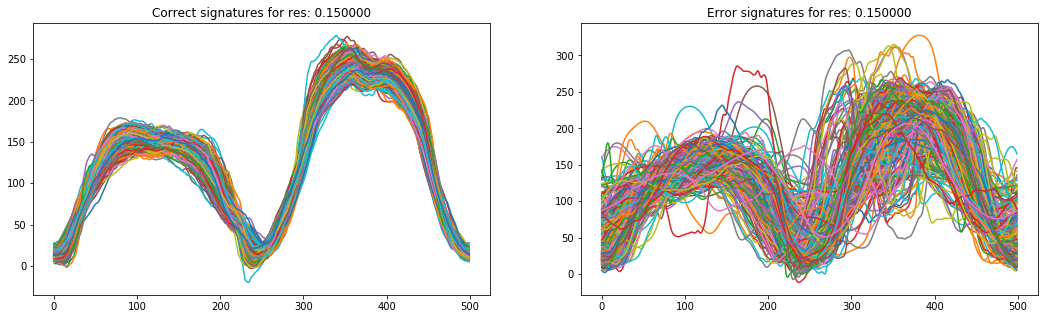

In [3]:
resols = np.arange(df_conf.RESOLS_INF,df_conf.RESOLS_SUP,df_conf.RESOLS_STEP)
resols = np.insert(resols,0,df_conf.FIT_RES)
prof_vec = np.empty((len(dirs_all),resols.shape[0],df_conf.POINTS))
reg_ex = np.round(0.3*df_conf.RESOLS_SUP/df_conf.RESOLS_STEP).astype('uint8')

for ind, mask_path in enumerate(dirs_all):
    pardoe_seg = glob.glob('{}*.corrected.cc.nii'.format(mask_path))
    if pardoe_seg != []:
        img_mask_msp = nib.load(pardoe_seg[0]).get_data()[::-1,::-1,0]
    else:
        file_mask_reg = '{}mask_reg'.format(mask_path)
        msp_points_reg = '{}msp_points_reg'.format(mask_path)

        in_img_msp = nib.load('{}.nii.gz'.format(msp_points_reg)).get_data()
        msp = np.argmax(np.sum(np.sum(in_img_msp,axis=-1),axis=-1))

        in_img_mask = nib.load('{}.nii.gz'.format(file_mask_reg)).get_data()
        img_mask_msp = in_img_mask[msp]

    refer_temp = sign.sign_extract(img_mask_msp, resols, df_conf.SMOOTHNESS, df_conf.POINTS)
    prof_vec[ind] = refer_temp

    if ind > 0: #Fitting curves using the first one as basis
        prof_ref = prof_vec[0]
        prof_vec[ind] = sign.sign_fit(prof_ref[0], refer_temp, df_conf.POINTS)

print("Segmentations' vector: ", prof_vec.shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))

labels_True = np.array(labels_all)==0
labels_False = np.array(labels_all)==1

ax1.plot(prof_vec[labels_True,reg_ex].T)
ax1.set_title('Correct signatures for res: %f'%(resols[reg_ex]))
ax2.plot(prof_vec[labels_False,reg_ex].T)
ax2.set_title('Error signatures for res: %f'%(resols[reg_ex]))
plt.show()

In [4]:
Y_total = np.array(labels_all)
Y_filt = Y_total != 2 #Filtering labels {0:correct,1:error,2:soft_error}
Y_total = Y_total[Y_filt]
X_total = prof_vec[Y_filt,1:,:] #Filtering the fitting resolution
resols = resols[1:] #Filtering the fitting resolution
resols_ref = np.arange(1,len(resols)+1)

print("Arrays' size:",X_total.shape,Y_total.shape)
print('Dic labels count:',np.unique(Y_total, return_counts=True))
print('Initial division:', np.sum(Y_total)/len(Y_total))
split_train = split_valid = 0.3

sss = StratifiedShuffleSplit(n_splits=1, test_size=split_valid, train_size=split_train, random_state=33)
train_index, valid_index = next(sss.split(X_total, Y_total))
test_index = np.ones((len(Y_total))).astype('bool')
test_index[np.concatenate((train_index,valid_index))] = False
test_index = np.arange(len(Y_total))[test_index]
X_train = X_total[train_index]
X_valid = X_total[valid_index]
X_test = X_total[test_index]
Y_train = Y_total[train_index]
Y_valid = Y_total[valid_index]
Y_test = Y_total[test_index]

val_norm = np.amax(np.amax(X_train,axis=0),axis=-1).reshape(1,-1,1)
X_train_norm = X_train/val_norm
X_valid_norm = X_valid/val_norm
X_test_norm = X_test/val_norm

print('Train set: ({})'.format(split_train),X_train_norm.shape, Y_train.shape, np.sum(Y_train)/len(Y_train))
print('Valid set: ({})'.format(split_valid),X_valid_norm.shape, Y_valid.shape, np.sum(Y_valid)/len(Y_valid))
print('Test set: ({})'.format(1-(split_train+split_valid)), X_test_norm.shape,
      Y_test.shape,np.sum(Y_test)/len(Y_test))

Arrays' size: (688, 25, 500) (688,)
Dic labels count: (array([0, 1]), array([401, 287]))
Initial division: 0.4171511627906977
Train set: (0.3) (206, 25, 500) (206,) 0.4174757281553398
Valid set: (0.3) (207, 25, 500) (207,) 0.41545893719806765
Test set: (0.4) (275, 25, 500) (275,) 0.41818181818181815


--------------------------------------------------------------------
SVC(C=50, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=4, shrinking=True, tol=0.001,
  verbose=False)
Final AUC:  0.8440803382663847  at res:  0.01
--------------------------------------------------------------------
SVC(C=50, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=4, shrinking=True, tol=0.001,
  verbose=False)
Final AUC:  0.9435421871996925  at res:  0.03
--------------------------------------------------------------------
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=4, shrinking=True, tol=0.001,
  verbose=False)
Final AUC:  0.93772

--------------------------------------------------------------------
SVC(C=20, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=4, shrinking=True, tol=0.001,
  verbose=False)
Final AUC:  0.9410916778781471  at res:  0.48999999999999994


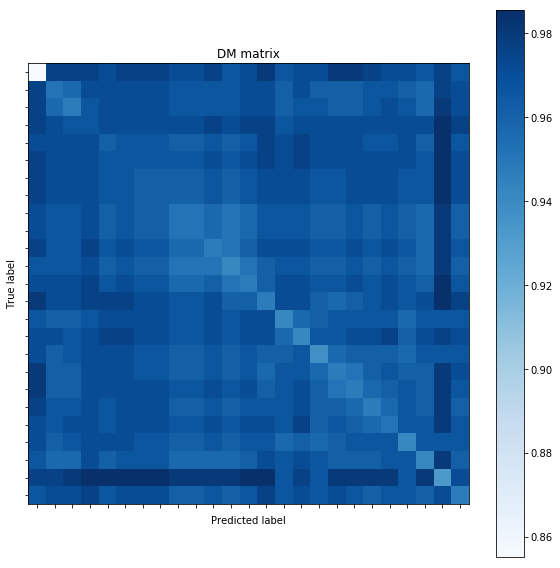

In [5]:
tuned_parameters = [{'kernel': ['rbf', 'linear'], 'C': [1, 10, 20, 50, 100]}]
cv_s = StratifiedKFold(5, shuffle=True, random_state=2)

acum_pred = np.array([]).reshape(0,Y_valid.shape[0])
d_train = {}
auc_vec = []
# Each resolution is used as feature shape alogn with one SVM classifier
# Select best hyperparameters for each resolution/classifier using CV
for res in np.arange(resols.shape[0]):
    d_train['string{0}'.format(res)] = GridSearchCV(svm.SVC(gamma='scale', class_weight='balanced', random_state=4,
                                                            probability=True,),
                                                    tuned_parameters, iid=False, cv=cv_s, scoring='roc_auc')
    d_train['string{0}'.format(res)].fit(X_train_norm[:,res,:], Y_train)
    print('--------------------------------------------------------------------')
    print(d_train['string{0}'.format(res)].best_estimator_)

    y_true, y_pred = Y_valid, d_train['string{0}'.format(res)].predict(X_valid_norm[:,res,:])
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc_vec.append(metrics.auc(fpr, tpr))
    print('Final AUC: ', auc_vec[-1], ' at res: ', resols[res])
    acum_pred = np.vstack((acum_pred, y_pred))

acum_acc = np.logical_not(np.logical_xor(acum_pred.astype('bool'),Y_valid.astype('bool')))

mm_conf = np.empty((4,acum_acc.shape[0],acum_acc.shape[0]))
for i in range(acum_acc.shape[0]):
    for j in range(acum_acc.shape[0]):
        mm_conf[:,i,j] = ax.agreement_matrix(acum_acc[i],acum_acc[j])

a = mm_conf[0]
b = mm_conf[1]
c = mm_conf[2]
d = mm_conf[3]

#DM = (a*d-b*c)/(a*d+b*c)
DM = (a+b+c)/(a+b+c+d)
#DM = (b+c)/(a+b+c+d)

ax.plot_matrix(DM, classes=map(str, resols),title='DM matrix')

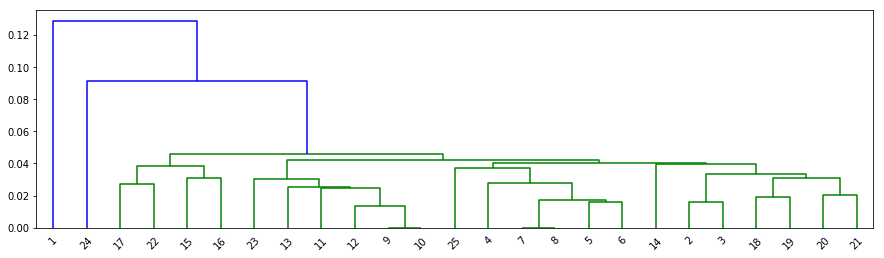

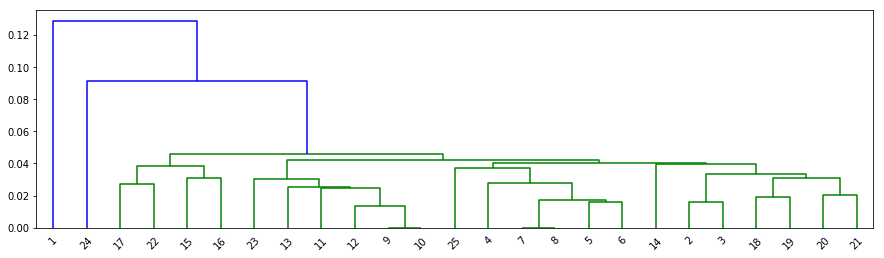

In [6]:
Z = linkage(DM, 'average', optimal_ordering=False)
label_z = np.arange(1,len(DM)+1)

fig = plt.figure(figsize=(15, 4))
dend = dendrogram(Z, labels=label_z)
plt.show()

th_auc = 0.8
auc_vec_th = np.array(auc_vec) > th_auc
label_z = label_z[auc_vec_th]

#Updating vectors
DM = DM[auc_vec_th][:,auc_vec_th]
resols_ref = resols_ref[auc_vec_th]
X_valid_norm = X_valid_norm[:,auc_vec_th,:]
X_test_norm = X_test_norm[:,auc_vec_th,:]

Z = linkage(DM, 'average', optimal_ordering=False)
fig = plt.figure(figsize=(15, 4))
dend = dendrogram(Z, labels=label_z)
plt.show()

Clusters: 1 Choosen resolutions: [12]
--------------------------------------------------------------------
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=16, shrinking=True,
  tol=0.001, verbose=False)
Number of clusters: 1  / Final AUC:  0.9080163043478261
Clusters: 2 Choosen resolutions: [12 24]
--------------------------------------------------------------------
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=16, shrinking=True,
  tol=0.001, verbose=False)
Number of clusters: 2  / Final AUC:  0.9198369565217391
Clusters: 3 Choosen resolutions: [12 24  1]
--------------------------------------------------------------------
SVC(C=20, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=

--------------------------------------------------------------------
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=16, shrinking=True,
  tol=0.001, verbose=False)
Number of clusters: 21  / Final AUC:  0.9403532608695653
Clusters: 22 Choosen resolutions: [18 24 12 22 21 25 23 17 20 15 11  1  7  8 14  4  3 13 16  2  5  6]
--------------------------------------------------------------------
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=16, shrinking=True,
  tol=0.001, verbose=False)
Number of clusters: 22  / Final AUC:  0.9403532608695653
Clusters: 23 Choosen resolutions: [12 24 25 22 21 19 23 17 20 15 18  1  7  8 14  4  3 13 16  2  5  6 11]
--------------------------------------------------------------------
SVC(C=1, cache_s

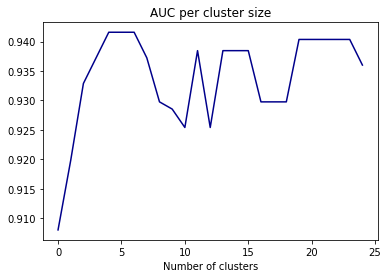

In [7]:
choose_el = 'min_dist'#'min_dist', 'random'
tuned_parameters_ens = [{'kernel': ['rbf', 'linear'], 'C': [1, 10, 20, 50, 100],}]
cv_ens = StratifiedKFold(5, shuffle=True, random_state=8)
num_clusters = np.arange(1,len(DM)+1)
clusters_auc = []

# All the possible clusters ranging from 1 (grouping all 49 resolutions) to 49 (one cluster for resolution)
for n_cl in num_clusters:
    agg = AgglomerativeClustering(n_clusters=n_cl, affinity='precomputed', linkage='average')
    labels_res = agg.fit_predict(DM)

    list_clusters = []
    res_chs = []
    labels_list = np.unique(labels_res)
    for clust in labels_list:
        res_clust = np.where(labels_res==clust)[0]
        list_clusters.append(res_clust)
        #print "Set({}): ".format(clust), resols_ref[res_clust]
        if choose_el == 'random':
            res_chs.append(random.choice(res_clust))
        else:
            sum_dist = []
            for r_clust in res_clust:
                sum_dist.append(np.sum(DM[r_clust,res_clust]))
            res_chs.append(res_clust[np.argmin(sum_dist)])
    print("Clusters:", len(list_clusters), "Choosen resolutions:", resols_ref[res_chs])

    svm_ind = np.array([]).reshape(0,Y_valid.shape[0])
    for res_ch in res_chs:
        svm_ind = np.vstack((svm_ind, d_train['string{0}'.format(res_ch)].predict_proba(X_valid_norm[:,res_ch,:])[:,1]))
    svm_ind = svm_ind.T
    clf = GridSearchCV(svm.SVC(gamma='scale', class_weight='balanced', random_state=16), tuned_parameters_ens, 
                       iid=False, cv=cv_ens, scoring='roc_auc')
    clf.fit(svm_ind, Y_valid)
    svm_ind = np.array([]).reshape(0,Y_test.shape[0])
    for res_ch in res_chs:
        svm_ind = np.vstack((svm_ind, d_train['string{0}'.format(res_ch)].predict_proba(X_test_norm[:,res_ch,:])[:,1]))
    svm_ind = svm_ind.T
    y_true, y_pred = Y_test, clf.predict(svm_ind)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    AUC_cl = metrics.auc(fpr, tpr)
    print('--------------------------------------------------------------------')
    print(clf.best_estimator_)
    print('Number of clusters:', n_cl, ' / Final AUC: ', AUC_cl)
    clusters_auc.append(AUC_cl)

plt.figure()
plt.plot(clusters_auc, color='darkblue')
plt.title('AUC per cluster size')
plt.xlabel('Number of clusters')
plt.show()

In [8]:
max_auc, min_auc = np.amax(clusters_auc), np.amin(clusters_auc)
pc_best_auc_exp = 0.99
num_clust_ch = np.where(clusters_auc > min_auc+pc_best_auc_exp*(max_auc-min_auc))[0][0]+1
print('Best cluster size: {} (with at least {} of best result)'.format(num_clust_ch,pc_best_auc_exp))

agg = AgglomerativeClustering(n_clusters=num_clust_ch, affinity='precomputed', linkage='average')
labels_res = agg.fit_predict(DM)
print('Element labels', labels_res)

list_clusters = []
res_chs = []
labels_list = np.unique(labels_res)
for clust in labels_list:
    res_clust = np.where(labels_res==clust)[0]
    list_clusters.append(res_clust)
    print("--------------------------------------------------------------------")
    if len(res_clust) == 1:
        dist_intra = np.amax(DM[res_clust[0],res_clust[0]])
    else:
        dist_intra = np.amax(DM[res_clust[0],res_clust[1:]])
    print('Cluster({}): '.format(clust),resols_ref[res_clust],'Distance intra: ',dist_intra)

    for res_ch in res_clust:
        y_true, y_pred = Y_test, d_train['string{0}'.format(res_ch)].predict(X_test_norm[:,res_ch,:])
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
        AUC_cl = metrics.auc(fpr, tpr)

        ind_err_rand = np.where(np.logical_xor(y_true, y_pred))
        ind_err = test_index[ind_err_rand]
        print('Element({}): '.format(resols_ref[res_ch]),ind_err, 'AUC:({})'.format(AUC_cl))

    if choose_el == 'random':
        res_chs.append(random.choice(res_clust))
    else:
        sum_dist = []
        for r_clust in res_clust:
            sum_dist.append(np.sum(DM[r_clust,res_clust]))
        res_chs.append(res_clust[np.argmin(sum_dist)])

Best cluster size: 5 (with at least 0.99 of best result)
Element labels [2 0 0 3 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
--------------------------------------------------------------------
Cluster(0):  [ 2  3  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25] Distance intra:  0.9710144927536232
Element(2):  [  4   9  10  60  66  67  68  79  95 110 114 122 131 154 157 185 217 236
 248 263 268 284 376 415] AUC:(0.8980978260869565)
Element(3):  [  4  60  67  68  79  83  95 110 114 122 154 157 162 217 236 238 248 263
 267 268 340 636] AUC:(0.9092391304347825)
Element(5):  [  9  21  35  66  67  68  79  95 110 154 157 185 203 217 236 248 263 268
 284 377] AUC:(0.9154891304347826)
Element(7):  [  9  60  66  67  68  79  95 110 114 122 131 157 162 185 203 217 236 248
 255 263 268 284 303 322 415 416] AUC:(0.8930706521739131)
Element(8):  [  9  60  66  67  68  79  83  95 110 114 157 162 185 203 217 236 248 255
 263 268 284 303] AUC:(0.9067934782608698)
Element(9):  [  9  21  60  66  6

Size ensemble: 5 Chosen resolutions: [12 24  1  4  6]
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
  max_iter=-1, probability=True, random_state=16, shrinking=True,
  tol=0.001, verbose=False)


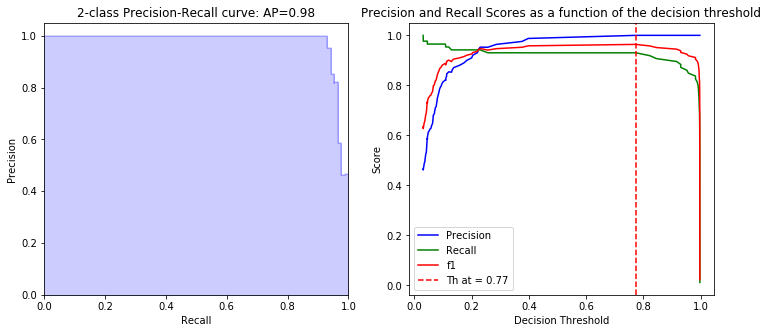

Best separation threshold: 0.7735011239144579


In [9]:
print('=========================================================================')
print("Size ensemble:", len(list_clusters), "Chosen resolutions:", resols_ref[res_chs])

svm_ind = np.array([]).reshape(0,Y_valid.shape[0])
for res_ch in res_chs:
    svm_ind = np.vstack((svm_ind, d_train["string{0}".format(res_ch)].predict_proba(X_valid_norm[:,res_ch,:])[:,1]))
svm_ind = svm_ind.T
clf = GridSearchCV(svm.SVC(gamma='scale', class_weight='balanced', random_state=16, probability=True), 
                   tuned_parameters_ens, iid=False, cv=cv_ens, scoring='roc_auc')

clf.fit(svm_ind, Y_valid)
print(clf.best_estimator_)

y_pred_probs = clf.predict_proba(svm_ind)[:,1]
__, opt_th = ax.plot_prc(Y_valid, y_pred_probs)

print('Best separation threshold: {}'.format(opt_th))

------------------------------------
ROC Curve Teste:


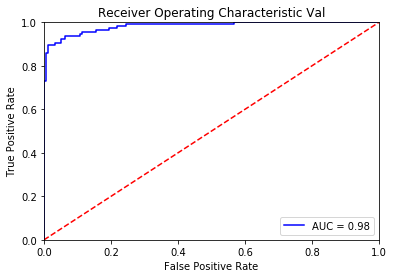

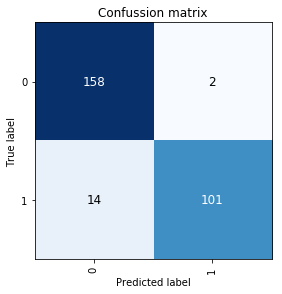

===== Final Report =====
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| AUC       | 0.982609 |
+-----------+----------+
| Accuracy  | 0.941818 |
+-----------+----------+
| Recall    | 0.878261 |
+-----------+----------+
| Precision | 0.980583 |
+-----------+----------+
| F1        | 0.926606 |
+-----------+----------+


In [10]:
svm_ind = np.array([]).reshape(0,Y_test.shape[0])
for res_ch in res_chs:
    svm_ind = np.vstack((svm_ind, d_train["string{0}".format(res_ch)].predict_proba(X_test_norm[:,res_ch,:])[:,1]))
svm_ind = svm_ind.T

y_pred_probs = clf.predict_proba(svm_ind)[:,1]
AUC_cl = ax.plot_roc(y_true, y_pred_probs)

y_pred = y_pred_probs > opt_th

mx_conf = confusion_matrix(y_true, y_pred)
ax.plot_matrix(mx_conf, classes=np.unique(y_true), fig_size=4,
            title='Confussion matrix', opt_bar=False)

ind_err_rand = np.where(np.logical_xor(y_true, y_pred))

accuracy, recall, precision, f1 = ax.report_metrics(mx_conf)

print('===== Final Report =====')
print(tabulate([['AUC', AUC_cl],
                ['Accuracy', accuracy],
                ['Recall', recall],
                ['Precision', precision],
                ['F1', f1],],
               ['Metric', 'Value'], tablefmt='grid'))

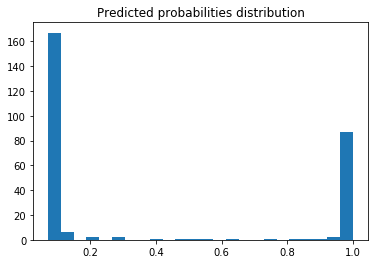

In [12]:
plt.hist(y_pred_probs,bins=24)
plt.title('Predicted probabilities distribution')
plt.show()

==================== Highest probabilities ====================


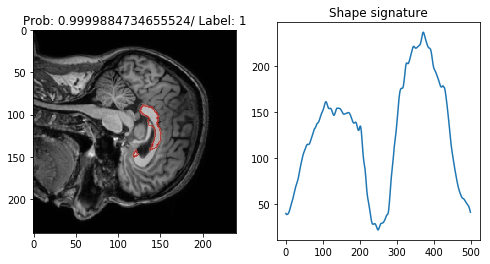

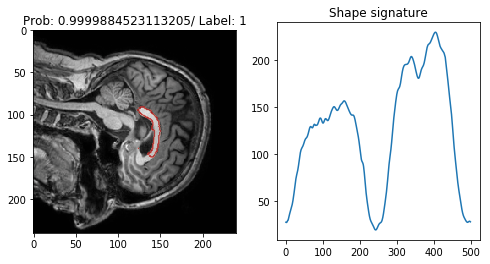

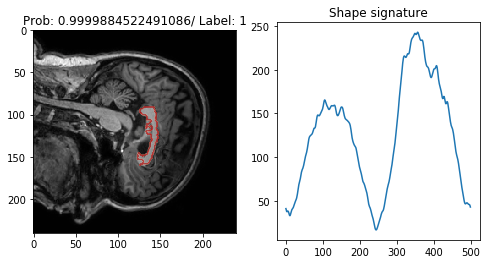

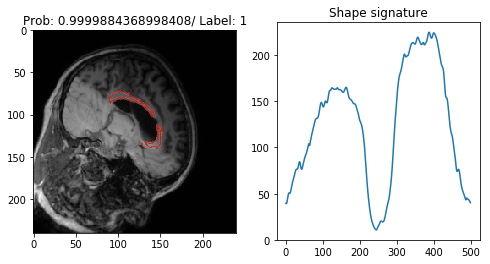

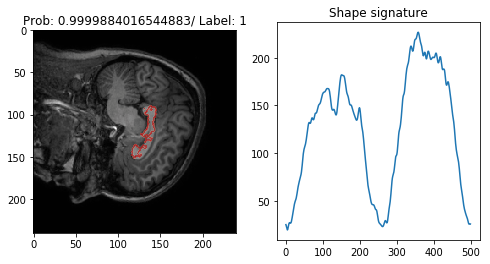

==================== Lowest probabilities ====================


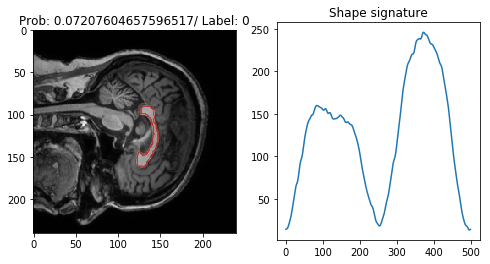

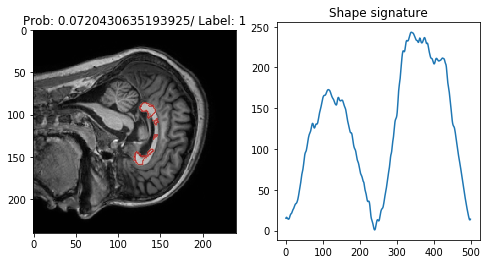

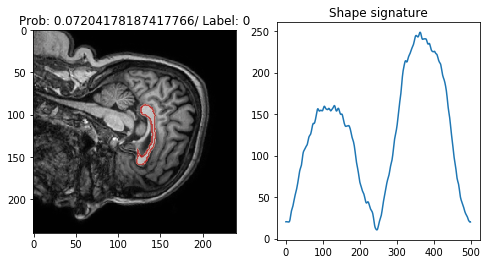

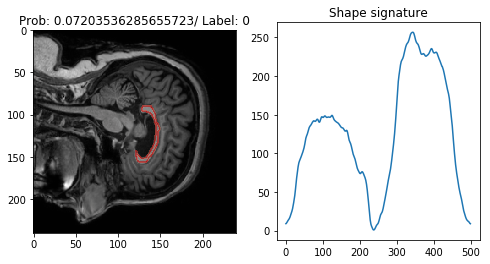

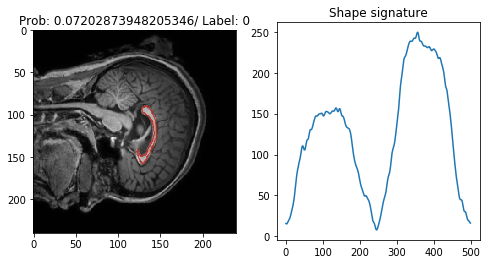

In [13]:
mycmap = ax.transparent_cmap(plt.cm.Reds)

dirs_test = np.array(dirs_all)[Y_filt][test_index]
prof_vec_test = prof_vec[Y_filt][test_index,reg_ex]

zipped_ord = sorted(zip(dirs_test,prof_vec_test,y_pred_probs,y_true),key = lambda t: t[2],reverse=True)

print('==================== Highest probabilities ====================')

for best_subj in zipped_ord[:5]:
    ax.print_mask_img(best_subj, mycmap)

print('==================== Lowest probabilities ====================')
    
for best_subj in zipped_ord[-5:]:
    ax.print_mask_img(best_subj, mycmap)

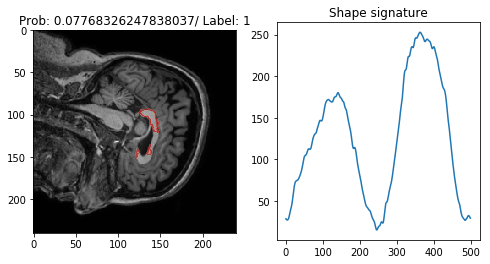

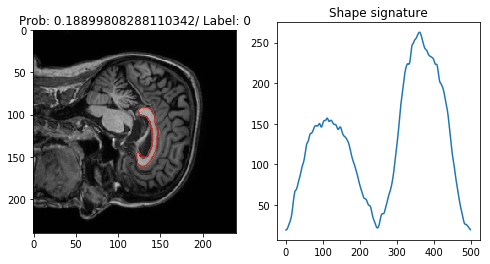

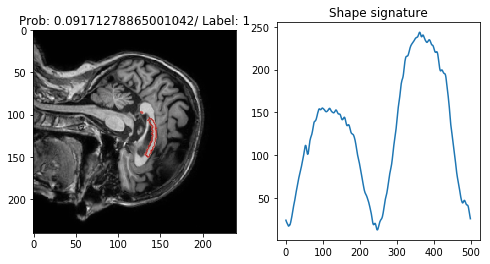

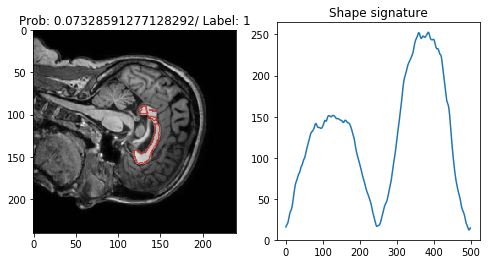

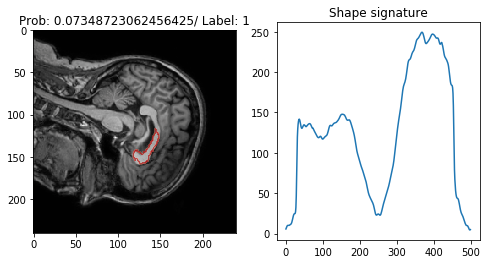

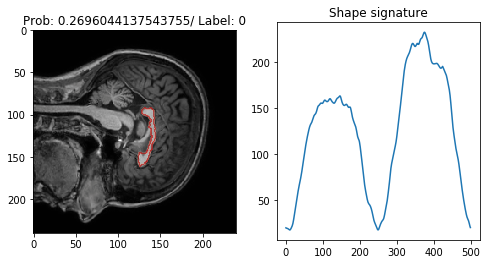

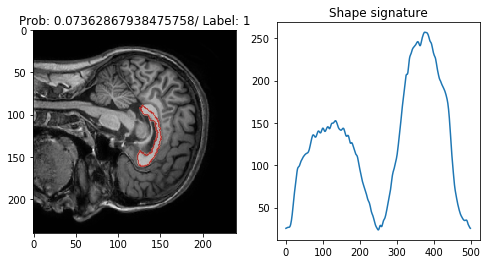

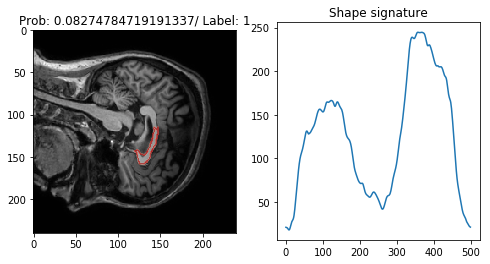

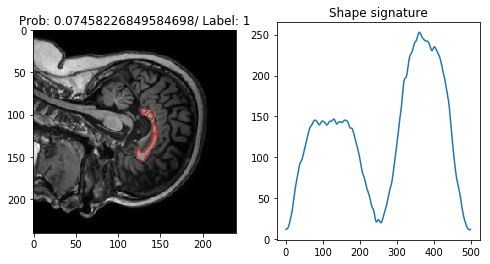

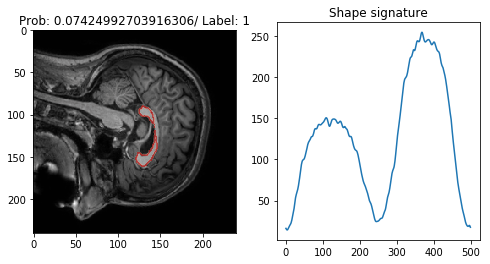

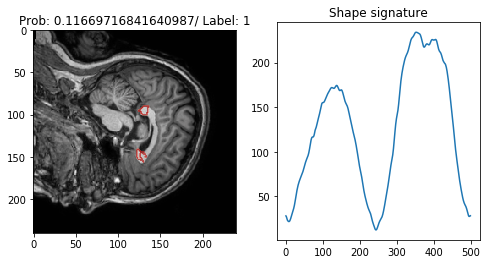

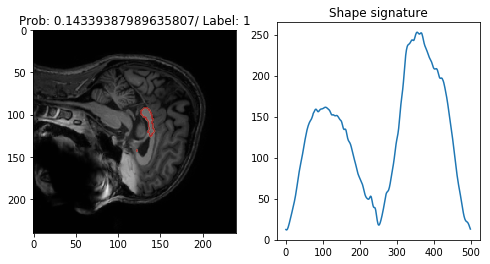

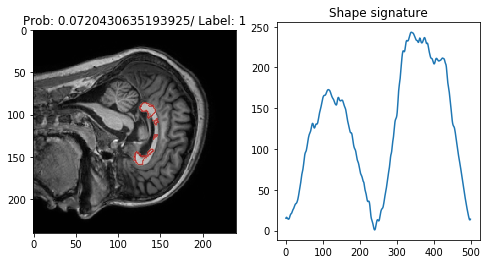

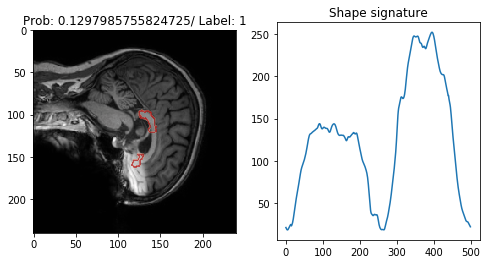

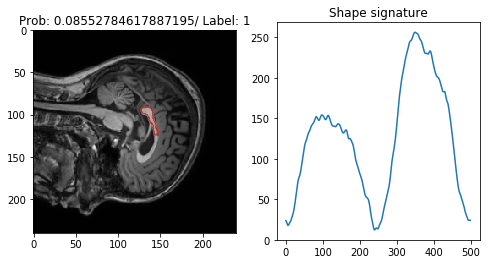

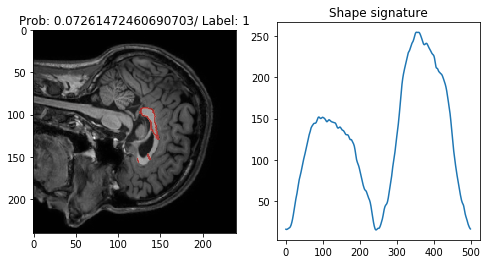

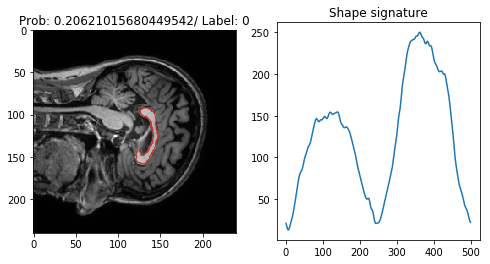

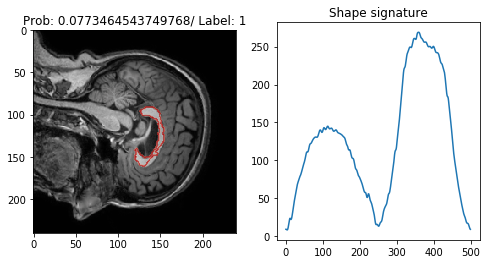

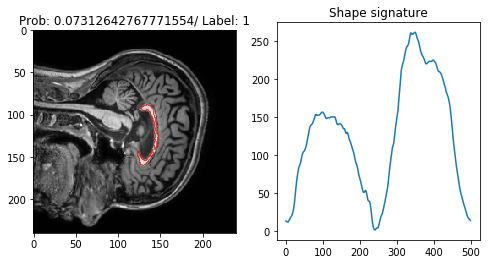

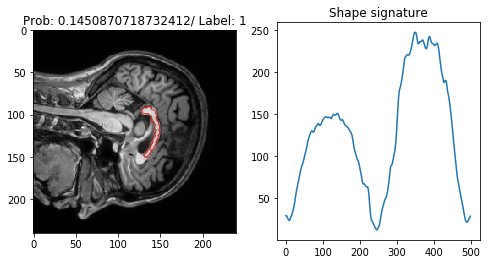

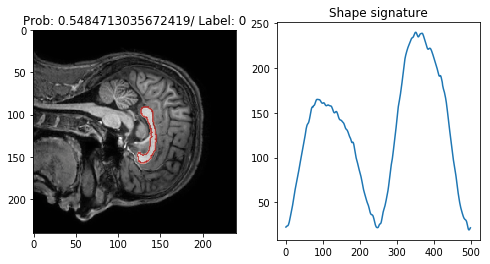

In [14]:
zipped = list(zip(dirs_test,prof_vec_test,y_pred_probs,y_true))

for i_err in ind_err_rand[0]:
    ax.print_mask_img(zipped[i_err], mycmap)